In [742]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pyfolio as pf


In [743]:
# Load the data into a dataframe
ticker =['M&M.NS']
df =yf.download(tickers=ticker,interval="1d",period="max")


[*********************100%%**********************]  1 of 1 completed


In [744]:
# Filter the data by date
df_window = df[df.index > datetime(2020,1,1,)]
df_window = df[df.index < datetime(2021,9,1)]

# # Print the result
df.head(4)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,41.431252,41.4375,40.768749,40.768749,26.277718,3600
1996-01-02,40.768749,40.6875,40.006248,40.187500,25.903072,15600
1996-01-03,24.112499,26.2500,25.500000,25.631250,16.520758,17600
1996-01-04,25.631250,25.7500,25.250000,25.500000,16.436163,8800


In [745]:
change = df["Close"].diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

window=14
avg_up = change_up.rolling(window=window).mean()
avg_down = change_down.rolling(window=window).mean().abs()

rsi = 100 * avg_up / (avg_up + avg_down)
rsi_dropna=rsi.dropna()
# Take a look at the 20 oldest datapoints
rsi_dropna.head(5)

Date
1996-01-19     8.492142
1996-01-22     8.764664
1996-01-23    53.333333
1996-01-24    50.000000
1996-01-25    56.043953
Name: Close, dtype: float64

In [746]:
# Set the theme of our chart
plt.style.use('fivethirtyeight')

# Make our resulting figure much bigger
plt.rcParams['figure.figsize'] = (20, 10)

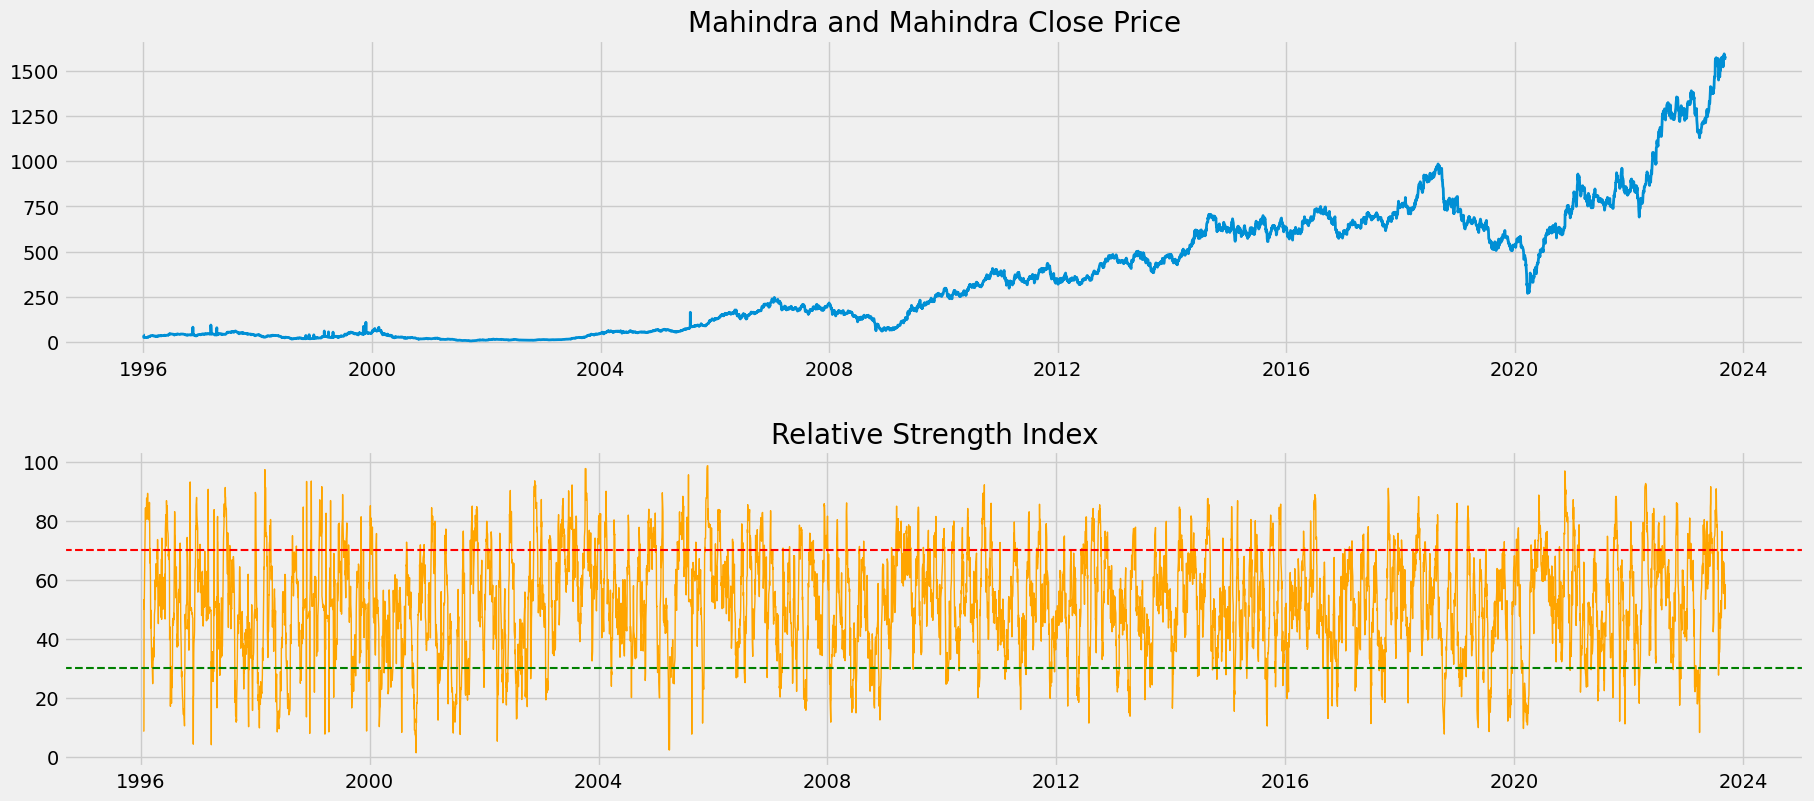

In [747]:
# Create two charts on the same figure.
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)

# First chart:
# Plot the closing price on the first chart
ax1.plot(df['Close'], linewidth=2)
ax1.set_title('Mahindra and Mahindra Close Price')

# Second chart
# Plot the RSI
ax2.set_title('Relative Strength Index')
ax2.plot(rsi, color='orange', linewidth=1)
# Add two horizontal lines, signalling the buy and sell ranges.
# Oversold
ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
# Overbought
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')


# Display the charts
plt.show()

In [748]:
fast_window=12
slow_window=20
df['bnh_returns']=np.log(df['Adj Close']/df['Adj Close'].shift(1))
df['Fast_SMA']=df['Adj Close'].rolling(window=fast_window).mean()
df['Slow_SMA']=df['Adj Close'].rolling(window=slow_window).mean()
df['RSI']=rsi
df.dropna(inplace=True)
df.head(10)


,Open,High,Low,Close,Adj Close,Volume,bnh_returns,Fast_SMA,Slow_SMA,RSI
Date,,,,,,,,,,
1996-01-26,26.250000,26.25000,26.250000,26.250000,16.919579,0,0.000000,16.426425,17.339545,60.956177
1996-01-29,26.250000,26.62500,25.625000,26.531250,17.100857,4000,0.010657,16.523780,16.880702,75.000011
1996-01-30,26.531250,28.12500,26.112499,28.125000,18.128119,249200,0.058336,16.679212,16.491955,80.487814
1996-01-31,27.500000,28.12500,26.256250,28.125000,18.128119,100800,0.000000,16.834644,16.572323,82.401912
1996-02-01,28.125000,29.37500,27.406250,29.343750,18.913673,445200,0.042421,17.048153,16.696198,84.486380
1996-02-02,28.125000,29.18750,28.125000,29.043751,18.720303,32400,-0.010276,17.252934,16.806176,80.439137
1996-02-05,29.043751,30.31250,28.500000,30.250000,19.497795,507600,0.040693,17.501355,16.968321,83.290722
1996-02-06,30.250000,30.25625,29.437500,29.950001,19.304434,68800,-0.009967,17.753807,17.146178,81.484580
1996-02-07,29.950001,30.96875,29.000000,30.462500,19.634764,67600,0.016967,18.033785,17.327258,81.773408


In [749]:
# Signal Matrix 
#Long Signal 
df['signal'] = np.where((df['RSI']<60) & (df['Fast_SMA'] > df['Slow_SMA']) &
                          (df['Fast_SMA'].shift(1) <= df['Slow_SMA']),1,0)

#Short Signal
df['signal'] = np.where((df['RSI']>70) & (df['Fast_SMA'] < df['Slow_SMA']) &
                          (df['Slow_SMA'].shift(1) <= df['Slow_SMA']),-1,df['signal'])

df['positions'] = df['signal'].replace(to_replace=0,method='ffill')
df['positions']=df['positions'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['positions'])




In [750]:
df['signal'].value_counts()

 0    6838
 1      93
-1      12
Name: signal, dtype: int64

Buy and hold returns: 4.528797755466137
Strategy returns: 8.64026241807916


<Axes: xlabel='Date'>

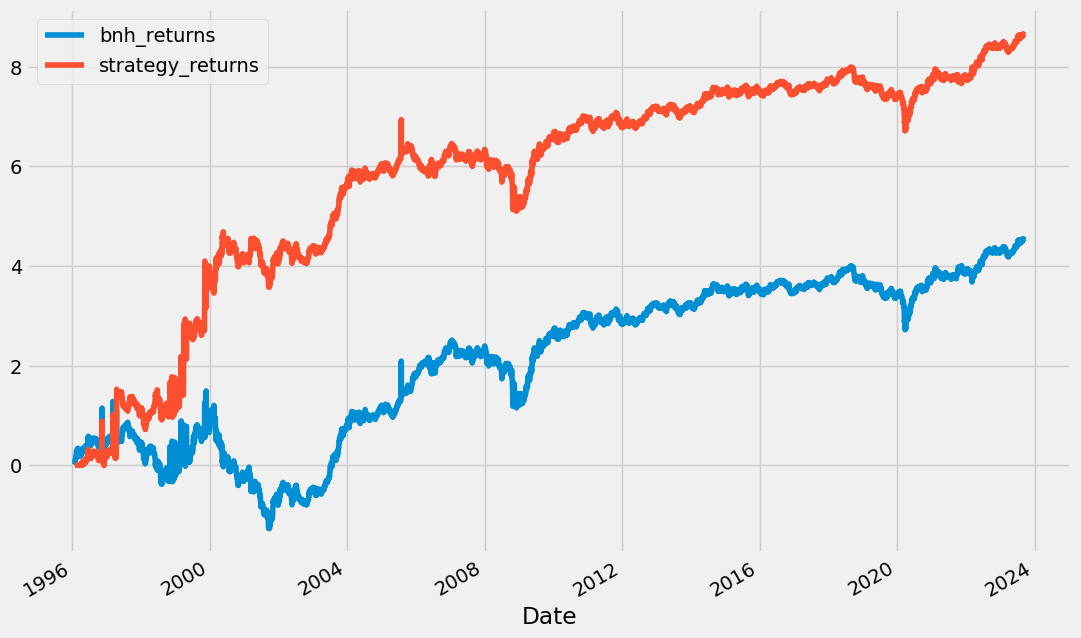

In [751]:
# comparing buy & hold strategy / RSI  strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,1996-01-26
End date,2023-09-08
Total months,330
,Backtest
Annual return,-1.4%
Cumulative returns,-32.2%
Annual volatility,75.9%
Sharpe ratio,0.41
Calmar ratio,-0.01
Stability,0.11
Max drawdown,-98.4%


c:\Users\paras\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


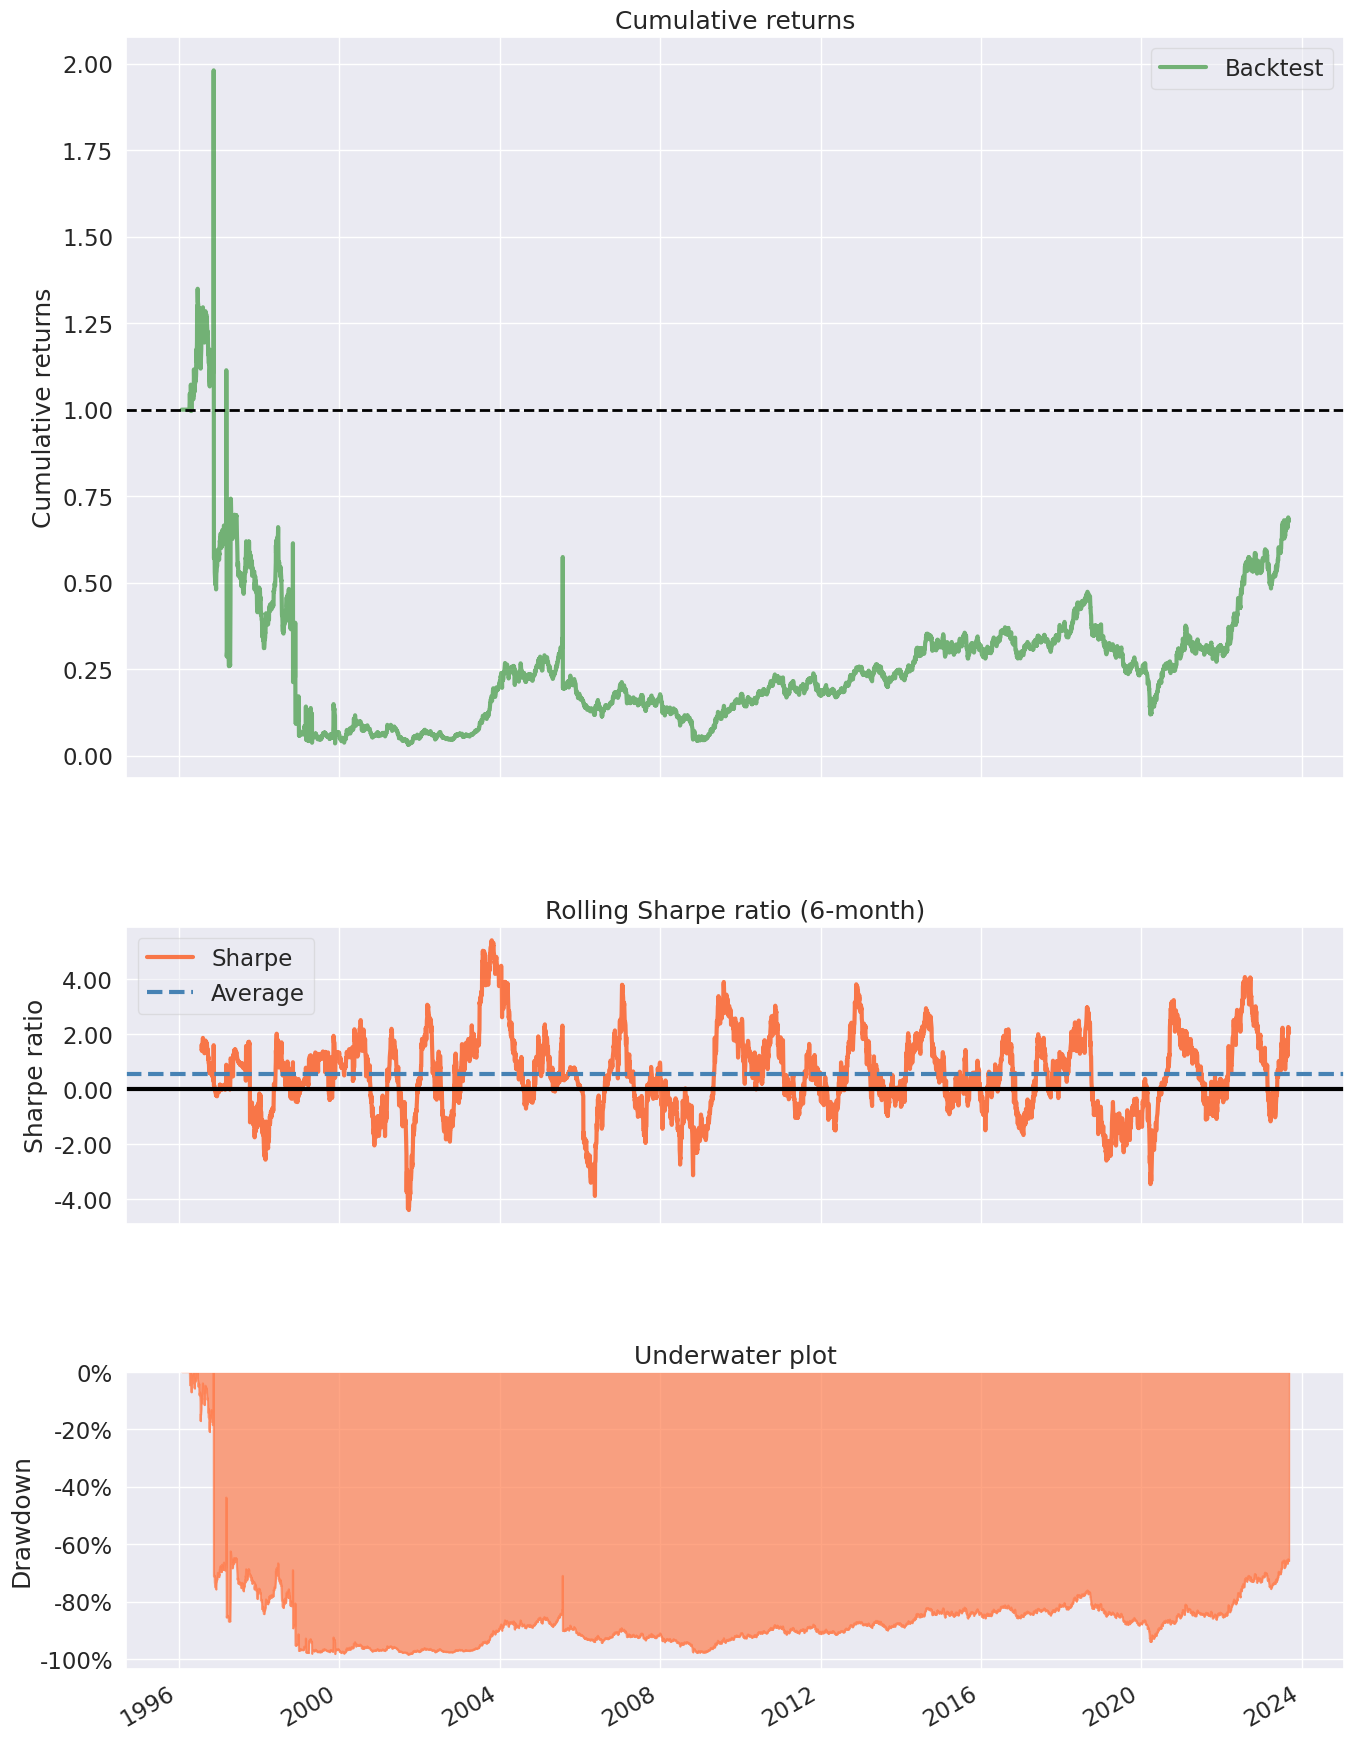

In [752]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())